In [676]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix

#- - - - - - - - - - - - - - - - - -
# Create a vector of size n_recipes named labels_recipes_cuisines that contains the cuisine ID
# create a list of size n_cuisines named label_unique_cuisines that contains the cuisine names
# create a list of size n_recipes named labels_recipe_names that contains the rceipes names

df_recipe_name = pd.read_csv("./CulinaryDB/01_Recipe_Details.csv")
labels_recipe_names= list(df_recipe_name["Title"])

labels_recipes_cuisines = list(df_recipe_name["Cuisine"])

label_unique_cuisines = list(set(labels_recipes_cuisines))

n_cuisines = len(label_unique_cuisines)

labels_recipes_cuisines_v = np.arange(len(labels_recipes_cuisines))
for ind in range(n_cuisines):
    matching_indices = np.asarray([index for index, element in enumerate(labels_recipes_cuisines) if element == label_unique_cuisines[ind]])
    labels_recipes_cuisines_v[matching_indices] = ind

labels_recipes_cuisines = labels_recipes_cuisines_v

#- - - - - - - - - - - - - - - - - -
# Create a binary matrix of size n_recipes x n_ingredients named sparse_matrix that contains the recipes and ingredients
# create a list of size n_ingredients named labels_ingredients_names that contains the ingredients names

df_recipe = pd.read_csv("./CulinaryDB/04_Recipe-Ingredients_Aliases.csv")

original_recipes_ID = np.asarray(df_recipe["Recipe ID"])
original_ingredients_ID = np.asarray(df_recipe["Entity ID"])

n_recipes = np.max(original_recipes_ID)
n_ingredients = np.max(original_ingredients_ID)

# Shape of matrix
rows, cols = n_recipes+1, n_ingredients+1  

# Indices of non-zero elements in the matrix
row_indices = original_recipes_ID  # Row positions to be set to 1
col_indices = original_ingredients_ID  # Column positions to be set to 1

# Create a COO matrix
modifications = coo_matrix((np.ones(original_ingredients_ID.size), (row_indices, col_indices)), shape=(rows, cols))

# Convert to CSR for efficient computations
sparse_matrix = modifications.tocsr()

# remove first row which is empty 
sparse_matrix = sparse_matrix[1:,:]

df_ingredient_1 = pd.read_csv("./CulinaryDB/02_Ingredients.csv")
df_ingredient_1 = df_ingredient_1[['Aliased Ingredient Name', 'Entity ID']]
df_ingredient_1.columns = ['Ingredient Name', 'Entity ID']
df_ingredient_2 = pd.read_csv("./CulinaryDB/03_Compound_Ingredients.csv")
df_ingredient_2 = df_ingredient_2[['Compound Ingredient Name', 'entity_id']]
df_ingredient_2.columns = ['Ingredient Name', 'Entity ID']
ingredient_df = pd.concat([df_ingredient_1, df_ingredient_2], axis=0)

labels_ingredients_names = []
ingredient_indices = []
for ind in range(sparse_matrix.shape[1]):
    n_elements = sparse_matrix[:,ind].size
    if n_elements > 0:
        result = ingredient_df[ingredient_df['Entity ID'] == ind]
        labels_ingredients_names.append(result.iloc[0,0])
        ingredient_indices.append(result.iloc[0,1])

sparse_matrix = sparse_matrix[:,ingredient_indices]

n_ingredients = len(ingredient_indices)



In [677]:
# remove recipes with to few ingredients
ingredient_thresh = 0
n_ingredient_recipes = sparse_matrix.sum(axis=1)
ind_empty_recipes = np.where(n_ingredient_recipes < ingredient_thresh)[0]

sparse_matrix = csr_matrix(np.delete(sparse_matrix.toarray(), ind_empty_recipes, axis=0))

labels_recipes_cuisines = np.delete(labels_recipes_cuisines, ind_empty_recipes)
for i in sorted(ind_empty_recipes, reverse=True):
    del labels_recipe_names[i]


EDA recipes

/var/folders/0t/lbpn_4td0gsc_q4xhmvhswqm0000gn/T/ipykernel_19741/2191573784.py:6: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/var/folders/0t/lbpn_4td0gsc_q4xhmvhswqm0000gn/T/ipykernel_19741/2191573784.py:7: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/var/folders/0t/lbpn_4td0gsc_q4xhmvhswqm0000gn/T/ipykernel_19741/2191573784.py:10: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/var/folders/0t/lbpn_4td0gsc_q4xhmvhswqm0000gn/T/ipykernel_19741/2191573784.py:18: D

maximum number of ingredient per recipe: 63
minimum number of ingredient per recipe: 0
median number of ingredient per recipe: 9
q25 number of ingredient per recipe: 3
q75 number of ingredient per recipe: 12


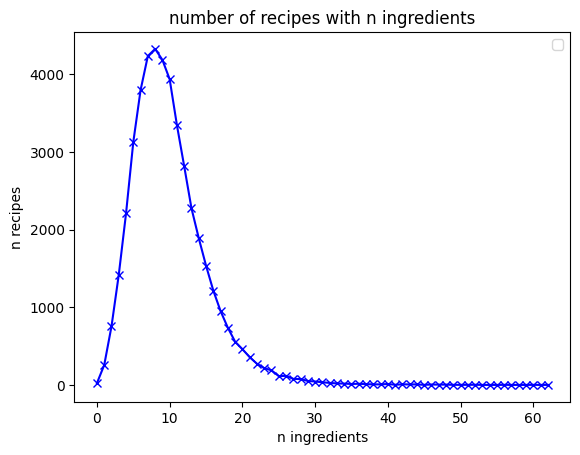

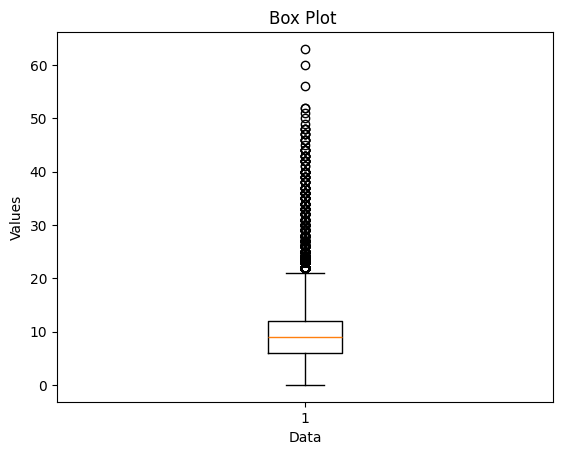

In [678]:
import matplotlib.pyplot as plt

n_ingredient_recipes = sparse_matrix.sum(axis=1)
mini = min(n_ingredient_recipes)
maxi = max(n_ingredient_recipes)
print("maximum number of ingredient per recipe: " + str(int(maxi[0])))
print("minimum number of ingredient per recipe: " + str(int(mini[0])))


x = np.arange(0, maxi)
y = np.zeros(x.size)

for ind in x:
    ind_1_ingredient_recipes = np.where(n_ingredient_recipes == ind)[0]
    y[int(ind)] = ind_1_ingredient_recipes.size

plt.plot(x, y, marker='x', color='b', linestyle='-')
print("median number of ingredient per recipe: " + str(int(np.median(n_ingredient_recipes,axis=0))))
print("q25 number of ingredient per recipe: " + str(int(np.percentile(n_ingredient_recipes, 5, axis=0))))
print("q75 number of ingredient per recipe: " + str(int(np.percentile(n_ingredient_recipes, 75, axis=0))))



#plt.yscale('log')

# Add labels and title
plt.xlabel("n ingredients")
plt.ylabel("n recipes")
plt.title("number of recipes with n ingredients")

# Show legend
plt.legend()

# Show the plot
plt.show()

plt.boxplot(n_ingredient_recipes)

# Add labels and title
plt.xlabel("Data")
plt.ylabel("Values")
plt.title("Box Plot ")

# Show the plot
plt.show()

EDA ingredient

(1, 695)
maximum number of recipes per ingredient: 21227
minimum number of recipes per ingredient: 1
median number of recipes per ingredient: 66
q25 number of recipes per ingredient: 1
q75 number of recipes per ingredient: 347


/var/folders/0t/lbpn_4td0gsc_q4xhmvhswqm0000gn/T/ipykernel_19741/3826419041.py:8: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/var/folders/0t/lbpn_4td0gsc_q4xhmvhswqm0000gn/T/ipykernel_19741/3826419041.py:9: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/var/folders/0t/lbpn_4td0gsc_q4xhmvhswqm0000gn/T/ipykernel_19741/3826419041.py:12: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/var/folders/0t/lbpn_4td0gsc_q4xhmvhswqm0000gn/T/ipykernel_19741/3826419041.py:19: D

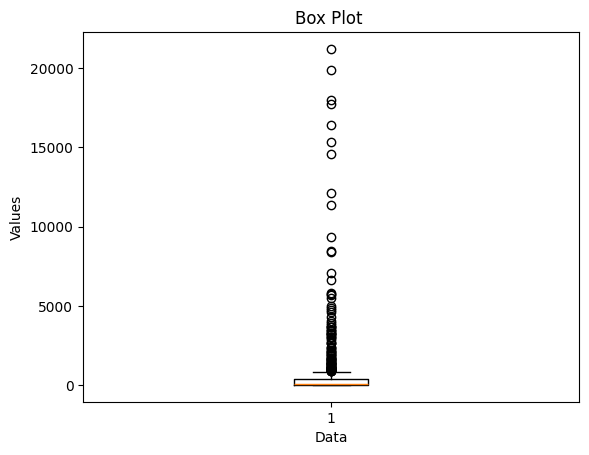

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


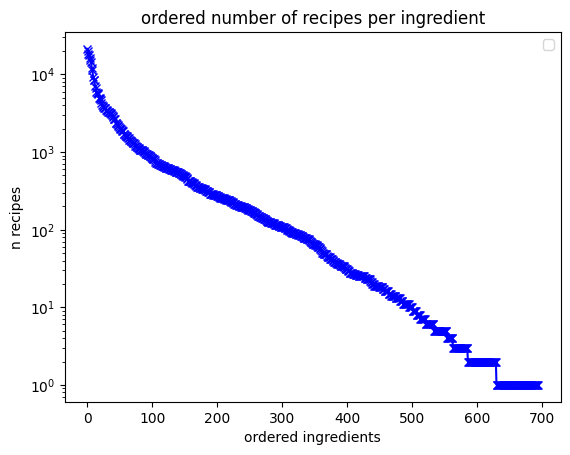

/var/folders/0t/lbpn_4td0gsc_q4xhmvhswqm0000gn/T/ipykernel_19741/3826419041.py:62: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



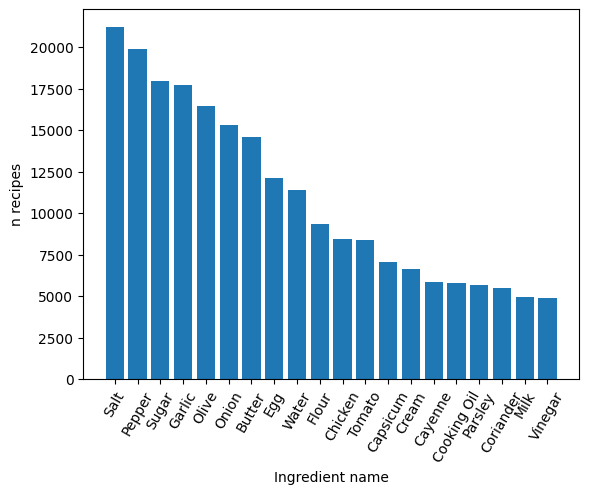

In [680]:
import matplotlib.pyplot as plt

n_recipes_per_ingredient = sparse_matrix.sum(axis=0)
print(n_recipes_per_ingredient.shape)
n_recipes_per_ingredient = n_recipes_per_ingredient.T
mini = min(n_recipes_per_ingredient)
maxi = max(n_recipes_per_ingredient)
print("maximum number of recipes per ingredient: " + str(int(maxi[0])))
print("minimum number of recipes per ingredient: " + str(int(mini[0])))


x = np.arange(0, maxi)
y = np.zeros(x.size)

for ind in x:
    ind_1_ingredient_recipes = np.where(n_recipes_per_ingredient == ind)[0]
    y[int(ind)] = ind_1_ingredient_recipes.size

print("median number of recipes per ingredient: " + str(int(np.median(n_recipes_per_ingredient,axis=0))))
print("q25 number of recipes per ingredient: " + str(int(np.percentile(n_recipes_per_ingredient, 5, axis=0))))
print("q75 number of recipes per ingredient: " + str(int(np.percentile(n_recipes_per_ingredient, 75, axis=0))))

plt.boxplot(n_recipes_per_ingredient)

# Add labels and title
plt.xlabel("Data")
plt.ylabel("Values")
plt.title("Box Plot ")

# Show the plot
plt.show()
#- - - - - - - - - - - - - - - - - - - -

sorted_n_recipes_per_ingredient = np.flipud(np.sort(n_recipes_per_ingredient,axis=0))
sorted_indices = np.flipud(np.argsort(n_recipes_per_ingredient,axis=0))

plt.plot(np.arange(n_recipes_per_ingredient.size), sorted_n_recipes_per_ingredient, marker='x', color='b', linestyle='-')

# Add labels and title
plt.xlabel("ordered ingredients")
plt.ylabel("n recipes")
plt.title("ordered number of recipes per ingredient")
plt.yscale('log')


# Show legend
plt.legend()

# Show the plot
plt.show()


#- - - - - - - - - - -- - - - - - - - - - - - 
#print n more frequent ingredients 
n = 20
indices = sorted_indices[0:n]

x = []
y = []
for count, idx in enumerate(indices, start=1):
    x.append(labels_ingredients_names[idx[0,0]])
    y.append(int(n_recipes_per_ingredient[idx[0,0]].astype(int)))
plt.bar(x, y)

# Add labels and title
plt.xlabel('Ingredient name')
plt.ylabel('n recipes')
plt.xticks(rotation=60)

# Show the plot
plt.show()

In [690]:
print(np.max(frequency_ingredients_per_cuisine))

1.175


EDA cuisine

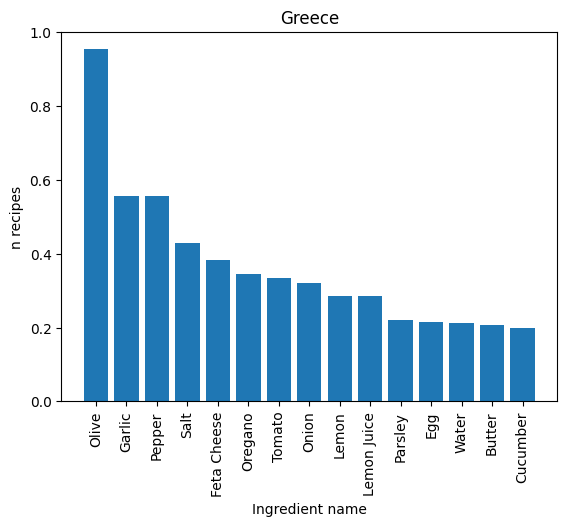

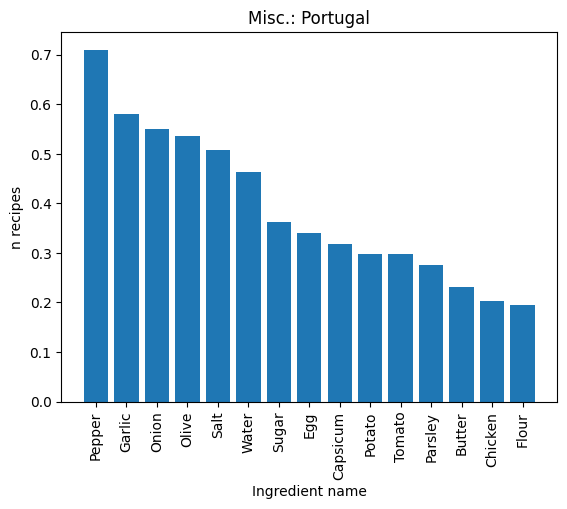

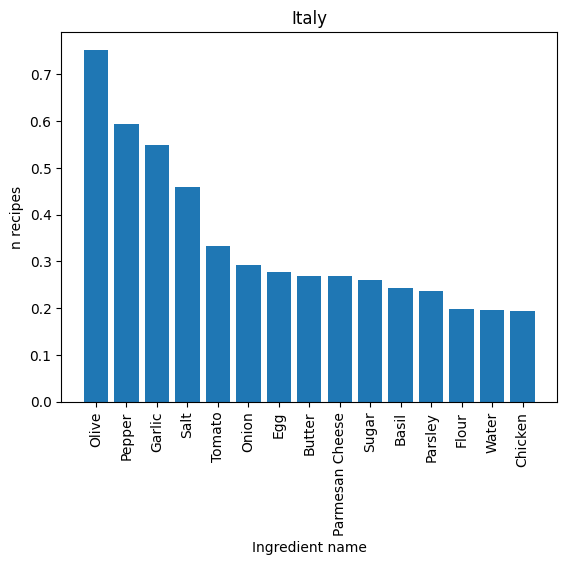

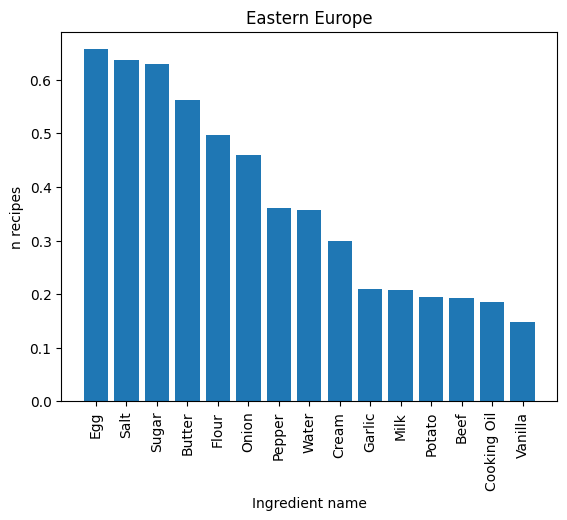

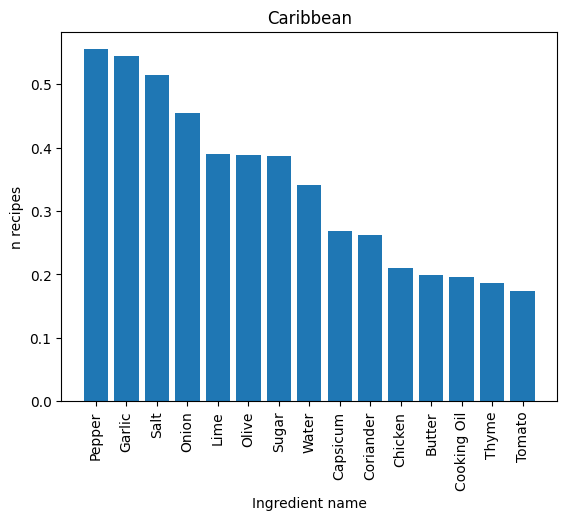

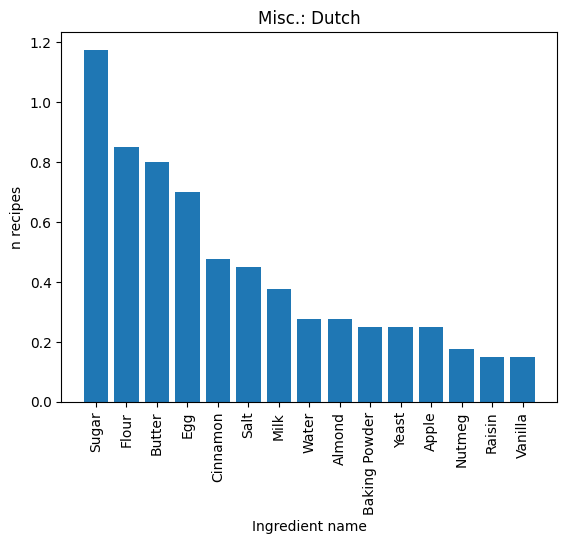

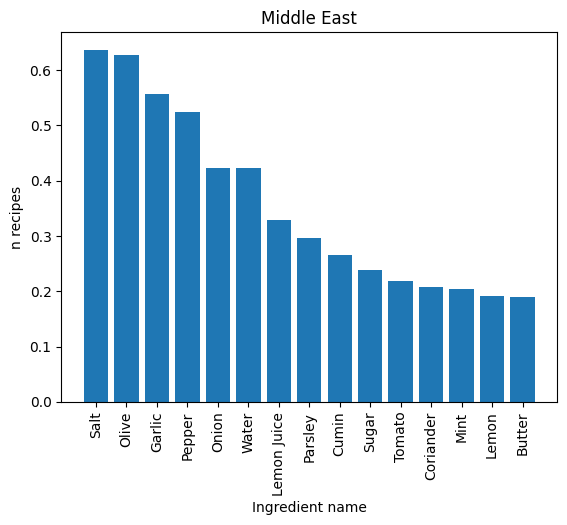

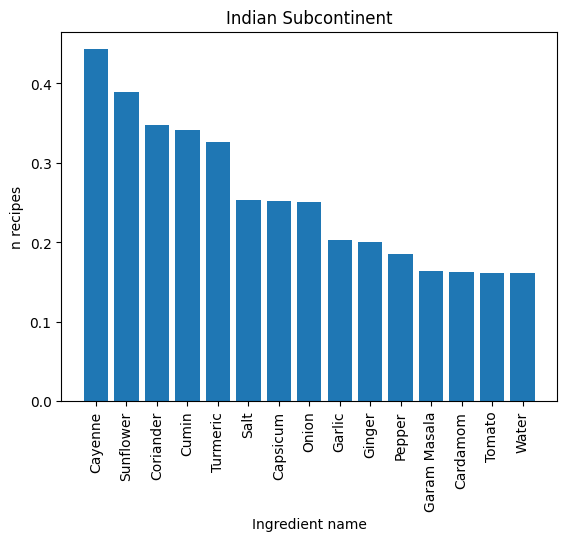

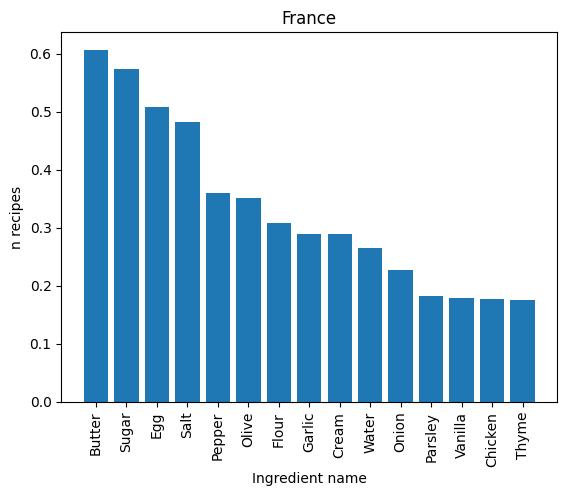

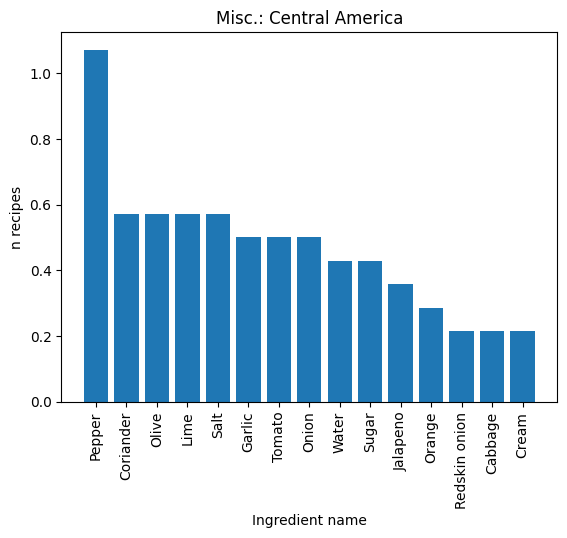

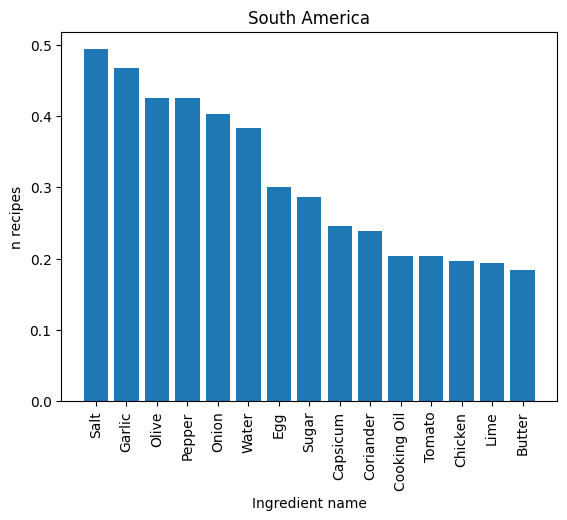

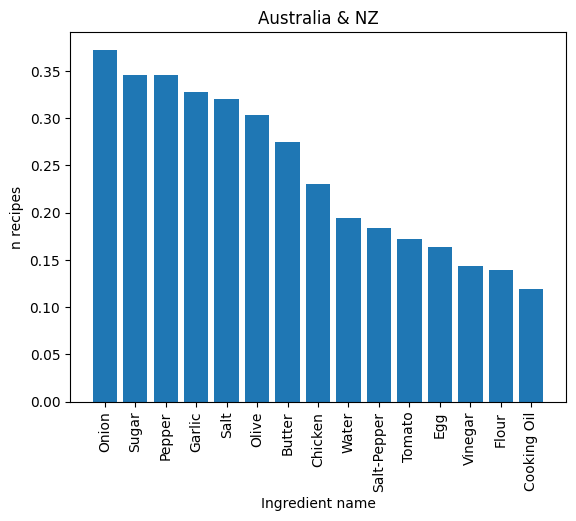

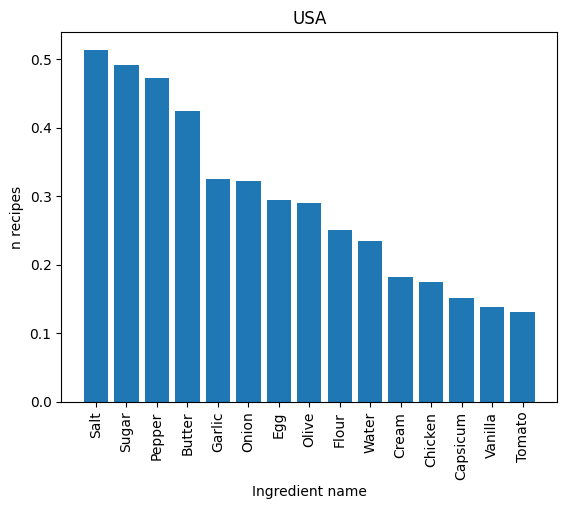

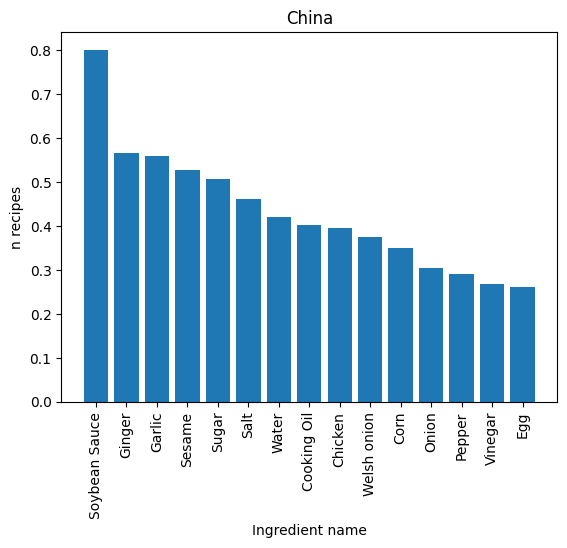

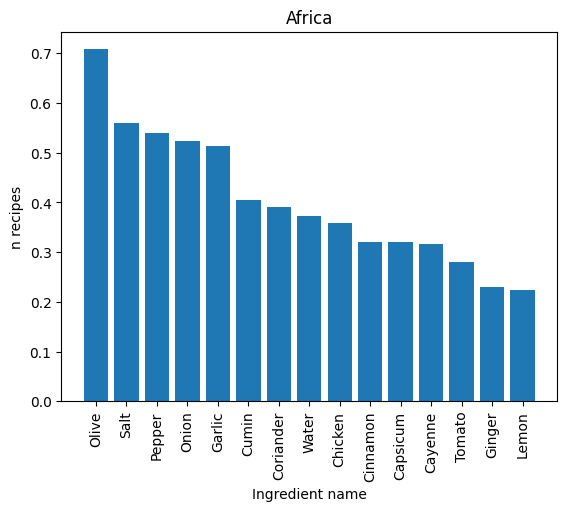

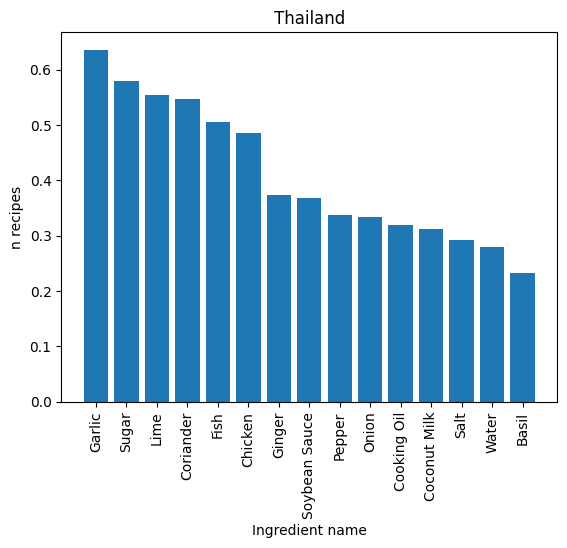

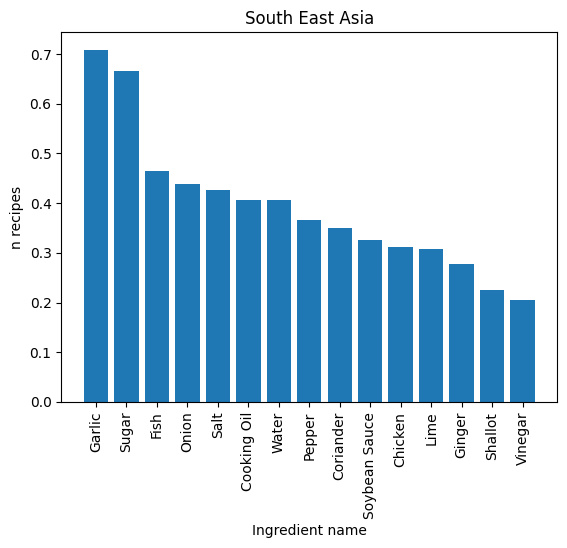

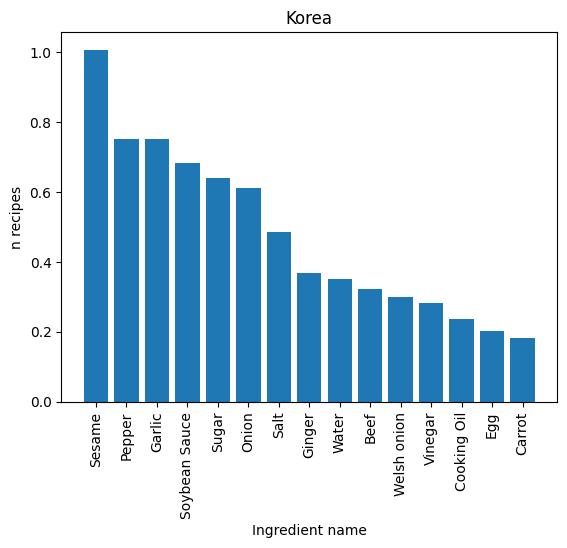

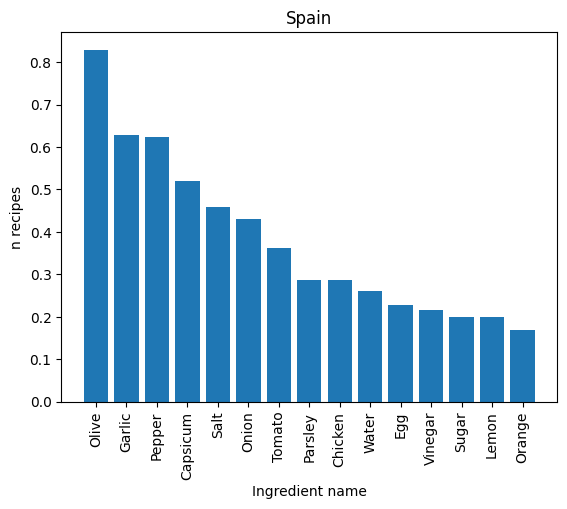

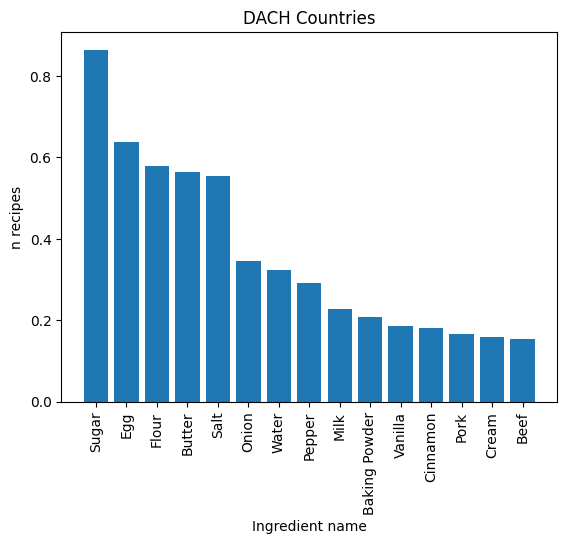

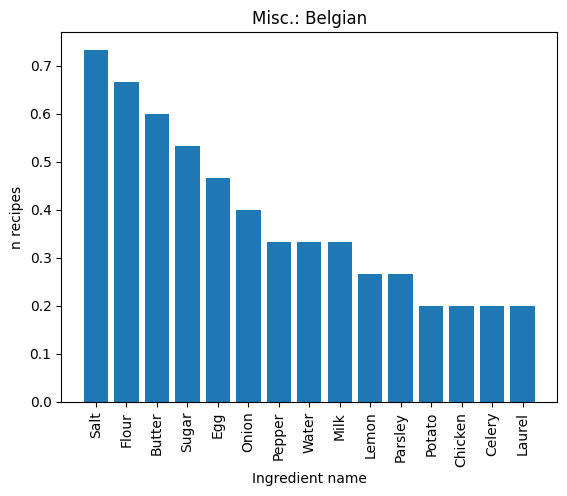

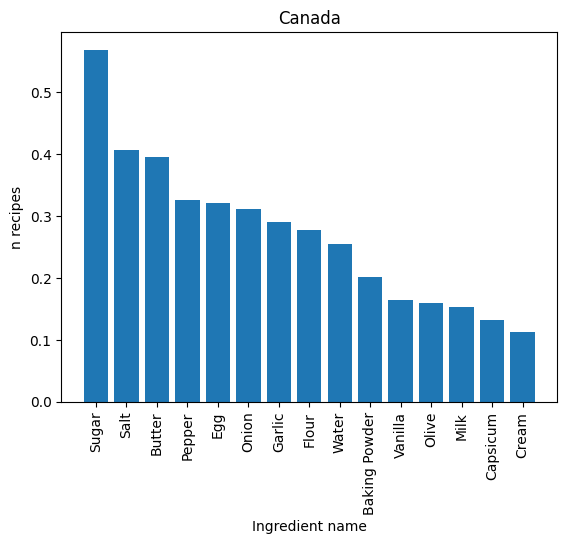

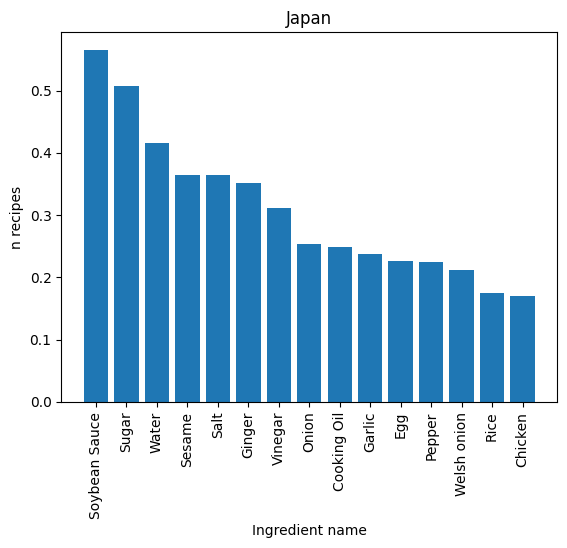

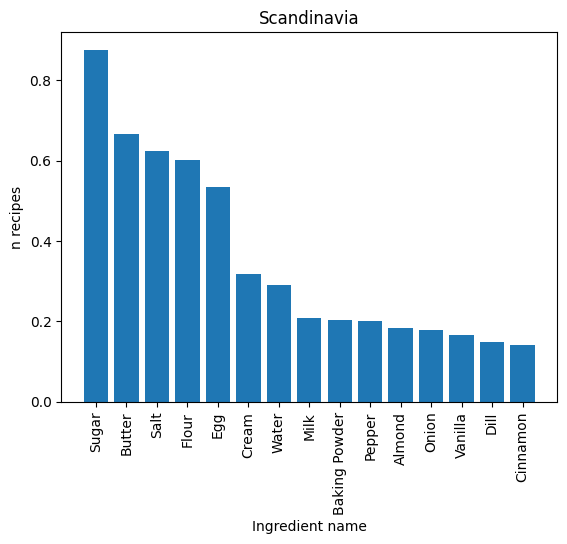

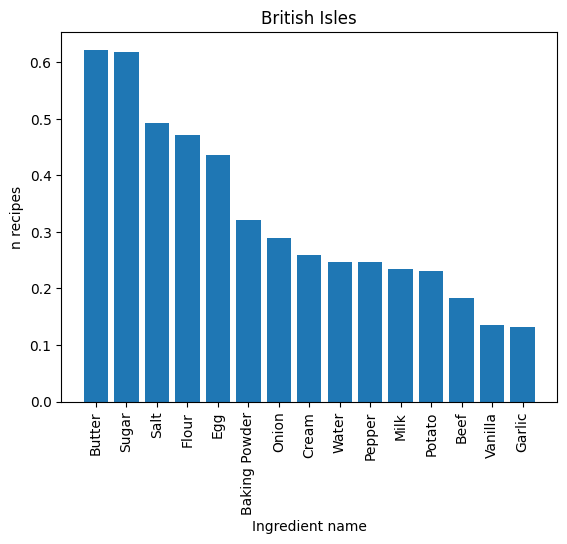

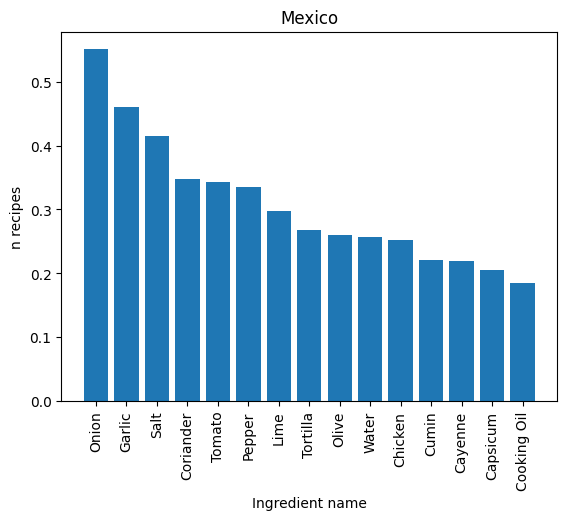

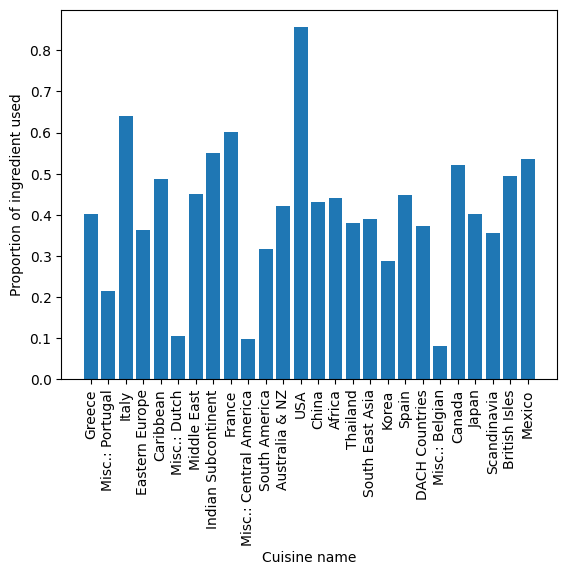

median proportion of total number of ingredient used in each cuisine is 41%


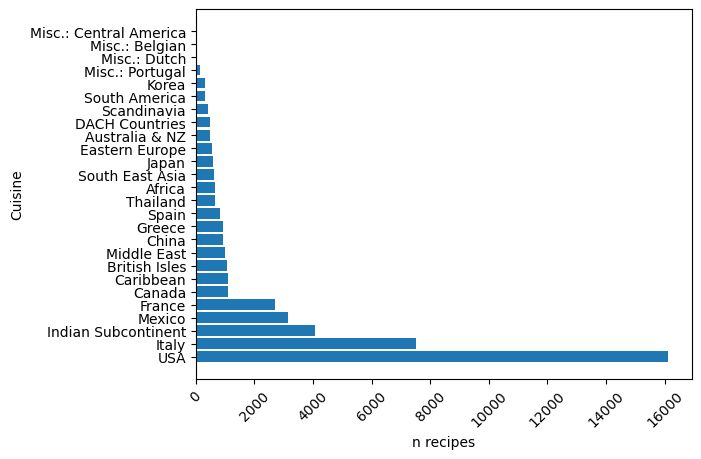

In [682]:

#- - - - - - - - - - -- - - - - - - - - - - - 
#print n more frequent ingredients 
n_cuisine = len(label_unique_cuisines)
frequency_ingredients_per_cuisine = np.zeros([n_cuisine,n_ingredients])
n = 15
mat = sparse_matrix.todense()  


for ind in np.unique(labels_recipes_cuisines):
    cuisine_sparse_matrix = mat[labels_recipes_cuisines == ind,:]
    n_recipes_per_ingredient_cuisine = np.asarray(cuisine_sparse_matrix.sum(axis=0))

    frequency_ingredients_per_cuisine[ind,:] = n_recipes_per_ingredient_cuisine/sum(labels_recipes_cuisines == ind)

    sorted_n_recipes_per_ingredient = np.fliplr(np.sort(n_recipes_per_ingredient_cuisine,axis=1))

    sorted_indices = np.fliplr(np.argsort(n_recipes_per_ingredient_cuisine,axis=1))
    indices = np.asarray(sorted_indices[:,0:n].T)
    x = []
    y = []
    for count, idx in enumerate(indices, start=1):

        x.append(labels_ingredients_names[idx[0]])
        y.append(int(n_recipes_per_ingredient_cuisine[0,idx[0]]))

    plt.bar(x, y/sum(labels_recipes_cuisines == ind))

    # Add labels and title
    plt.xlabel('Ingredient name')
    plt.ylabel('n recipes')
    plt.xticks(rotation=90)
    plt.title(label_unique_cuisines[ind])
    # Show the plot
    plt.show()

# plot frequency of total ingredient used
proportion_ingredient_used_per_cuisine = 1-np.sum(frequency_ingredients_per_cuisine == 0, axis=1)/n_ingredients


plt.bar(label_unique_cuisines, proportion_ingredient_used_per_cuisine)

# Add labels and title
plt.xlabel('Cuisine name')
plt.ylabel('Proportion of ingredient used')
plt.xticks(rotation=90)
# Show the plot
plt.show()

#- - - - - - - - - - - - - - - - - - - - - - - - -

n_recipes_per_cuisine = np.zeros(len(label_unique_cuisines))
for ind in labels_recipes_cuisines:
    n_recipes_per_cuisine[ind] = np.count_nonzero(labels_recipes_cuisines == ind)

indices = np.flipud(np.argsort(n_recipes_per_cuisine))

labels = np.array(label_unique_cuisines)


# Create bar chart
plt.barh(labels[indices], n_recipes_per_cuisine[indices])

# Add labels and title
plt.xlabel('n recipes')
plt.ylabel('Cuisine')
plt.xticks(rotation=45)

print("median proportion of total number of ingredient used in each cuisine is " + str(int(100*np.median(proportion_ingredient_used_per_cuisine))) + "%")
#- - - - - - - - - - - - - - - - - - - - - - - - -

Similarity cuisines


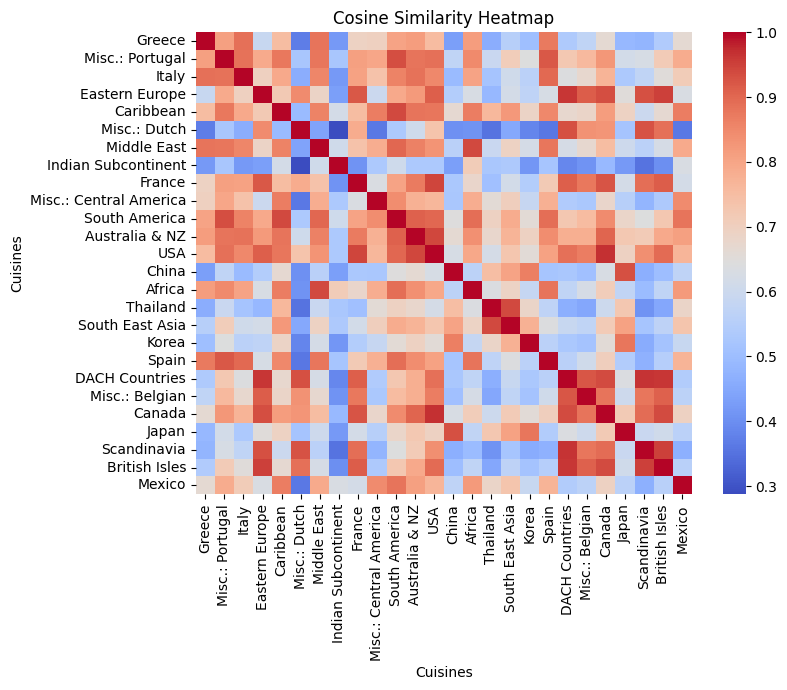

In [693]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns


n_ingredient_to_keep = 200

if len(n_recipes_per_ingredient.shape)>1:
    n_recipes_per_ingredient = np.array(n_recipes_per_ingredient)[:,0]
ind_most_frequent_ingredient = np.argsort(n_recipes_per_ingredient)[-n_ingredient_to_keep:][::-1]


#frequency_ingredients_per_cuisine
frequency_top_ing_per_cuisine = frequency_ingredients_per_cuisine[:,ind_most_frequent_ingredient]

similarity_matrix = cosine_similarity(frequency_top_ing_per_cuisine)

plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix, cmap="coolwarm", xticklabels=labels, yticklabels=labels, cbar=True)

# Titles and labels
plt.title("Cosine Similarity Heatmap")
plt.xlabel("Cuisines")
plt.ylabel("Cuisines")

# Show the plot
plt.show()

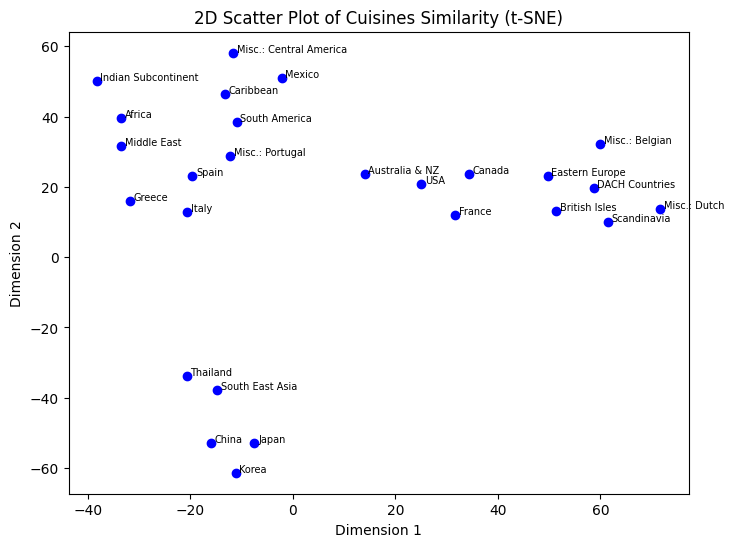

In [739]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import pdist, squareform

tsne = TSNE(n_components=2, random_state=42, metric="precomputed", perplexity=5, init="random")  # Using precomputed similarity matrix
cosine_dist = np.clip(1 - similarity_matrix, 0, None) 
tsne_results = tsne.fit_transform(cosine_dist)  # Convert similarity to distance (1 - similarity)

# Create 2D scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c='blue', marker='o')

# Annotate each point with the cuisine name
for i, label in enumerate(labels):
    plt.text(tsne_results[i, 0] + 0.7, tsne_results[i, 1] + 0.2, label, fontsize=7)

# Titles and labels
plt.title("2D Scatter Plot of Cuisines Similarity (t-SNE)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

# Show the plot
plt.show()
                                                

Ingredient occurrence 

In [754]:
from itertools import combinations

sparse_matrix_small =sparse_matrix[:,ind_most_frequent_ingredient]

cooccurrence_matrix = np.zeros([len(ind_most_frequent_ingredient), len(ind_most_frequent_ingredient)])

for ind in range(n_recipes):
    temp_recipe = sparse_matrix_small[ind,:]
    ind_coocur = temp_recipe.nonzero()[1] 
    if(ind_coocur.size>0):
        if(ind_coocur.size>1):
            pairs_coocur = list(combinations(ind_coocur, 2))

            rows, cols = zip(*pairs_coocur)

            cooccurrence_matrix[rows, cols] += 1
            cooccurrence_matrix[cols,rows] += 1

cooccurrence_matrix = cooccurrence_matrix/n_recipes_per_ingredient[ind_most_frequent_ingredient]
cooccurrence_matrix = np.minimum(cooccurrence_matrix, cooccurrence_matrix.T)

cooccurrence_matrix[np.arange(cooccurrence_matrix.shape[1]),np.arange(cooccurrence_matrix.shape[1])]=1

In [755]:
import plotly.express as px
import numpy as np
# Create an interactive heatmap with labels
fig = px.imshow(cooccurrence_matrix, 
                labels=dict(x="Ingredients", y="Ingredients", color="Similarity"), 
                x=np.array(labels_ingredients_names)[ind_most_frequent_ingredient],  # Labels for x-axis
                y=np.array(labels_ingredients_names)[ind_most_frequent_ingredient],  # Labels for y-axis
                color_continuous_scale='Viridis', 
                title="Ingredient cooccurrence matrix")

# Show the plot
fig.show()


In [756]:
import plotly.graph_objects as go

tsne = TSNE(n_components=2, random_state=42, metric="precomputed", perplexity=3, init="random")  # Using precomputed similarity matrix
dist_mat = np.clip(1 - cooccurrence_matrix, 0, None) 
tsne_results = tsne.fit_transform(dist_mat ** 3)  # Convert similarity to distance (1 - similarity)


x = tsne_results[:, 0]
y = tsne_results[:, 1]

df = pd.DataFrame({
    'x': x,
    'y': y,
    'labels': np.array(labels_ingredients_names)[ind_most_frequent_ingredient]
})
fig = go.Figure(data=go.Scatter(
    x=df['x'], 
    y=df['y'],
    mode='markers+text',  # Show both markers and text (labels)
    #mode='markers',
    text=df['labels'],  # Add labels as text
    textposition='top center',  # Adjust position of labels
))

# Update layout for a cleaner look with labels
fig.update_layout(
    autosize=True,  # Automatically resize the plot
    title_x=0.5,  # Title centered
    showlegend=False,  # Hide legend (optional)
    xaxis=dict(showgrid=False),  # Optional: Hide gridlines for a cleaner look
    yaxis=dict(showgrid=False)   # Optional: Hide gridlines for a cleaner look
)

# Show the plot
fig.show()

In [764]:
import numpy as np
import scipy.cluster.hierarchy as sch
import plotly.graph_objects as go

# Example co-occurrence matrix
np.random.seed(42)
# Your existing vector v with labels
v = np.array(labels_ingredients_names)[ind_most_frequent_ingredient]

# Compute linkage matrix
linked = sch.linkage(1 - cooccurrence_matrix, method="ward")  # Convert similarity to distance

# Create a Plotly dendrogram-like plot
fig = go.Figure()

# Define the dendrogram structure
dendro = sch.dendrogram(linked, labels=v, no_plot=True)  # Use v for the labels
dendro_x = dendro['icoord']
dendro_y = dendro['dcoord']

# Add the lines (branches) to the figure
for x, y in zip(dendro_x, dendro_y):
    fig.add_trace(go.Scatter(x=x, y=y, mode='lines', line=dict(width=2, color='blue')))

# Customize the layout for zooming
fig.update_layout(
    title="Interactive Hierarchical Clustering of Ingredients",
    xaxis=dict(
        title="Ingredients",
        showgrid=False,
        tickvals=[(min(x) + max(x)) / 2 for x in dendro_x],  # Position labels at the bottom
        ticktext=v,  # Use your existing labels
        tickangle=90,  # Rotate the labels 90 degrees to make them horizontal
    ),
    yaxis=dict(title="Distance", showgrid=False),
    hovermode='closest',  # Show info when hovering
    showlegend=False,
    plot_bgcolor="white"
)

# Show the interactive plot
fig.show()


/var/folders/0t/lbpn_4td0gsc_q4xhmvhswqm0000gn/T/ipykernel_19741/2469644267.py:11: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix

